# Gradient boosting regresion

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor as KNN

In [10]:
train = pd.read_csv("phone_train.csv")
test = pd.read_csv("phone_validation.csv")
y_train = train.loc[:,'y']

In [11]:
print(train.info())
is_null = train.isna()
is_null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 99 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tariff.plan          10000 non-null  int64  
 1   payment.method       10000 non-null  object 
 2   sex                  10000 non-null  object 
 3   age                  10000 non-null  float64
 4   activation.zone      10000 non-null  int64  
 5   activation.channel   10000 non-null  int64  
 6   vas1                 10000 non-null  object 
 7   vas2                 10000 non-null  object 
 8   q01.out.ch.peak      10000 non-null  int64  
 9   q01.out.dur.peak     10000 non-null  int64  
 10  q01.out.val.peak     10000 non-null  float64
 11  q01.out.ch.offpeak   10000 non-null  int64  
 12  q01.out.dur.offpeak  10000 non-null  int64  
 13  q01.out.val.offpeak  10000 non-null  float64
 14  q01.in.ch.tot        10000 non-null  int64  
 15  q01.in.dur.tot       10000 non-null  

,tariff.plan,payment.method,sex,age,activation.zone,activation.channel,vas1,vas2,q01.out.ch.peak,q01.out.dur.peak,...,q09.out.dur.peak,q09.out.val.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.in.ch.tot,q09.in.dur.tot,q09.ch.sms,q09.ch.cc,y
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
def get_categorical_features(X):
    column_types = X.dtypes
    categorical_features = column_types[column_types == 'object'].index.tolist()
    return categorical_features

def rm_feature(X, omitted_features):
    X = X.drop(columns=omitted_features)
    return X


cat_features = get_categorical_features(rm_feature(train, ['y']))
# also add the numerical categorical features
cat_features = cat_features + ['activation.zone', 'activation.channel','tariff.plan']
non_cat_features = ['age']

# just to have overviue of features

raw_concat = pd.concat((train, test))
unique_values = {}
for feature in cat_features:
    unique_values[feature] = raw_concat[feature].unique()

# categorical features: ['payment.method', 'sex', 'vas1', 'vas2', 'activation.zone', 'activation.channel', 'tariff.plan']

# to better see if somenumerical class missing 
unique_values['activation.zone'].sort()
unique_values['activation.channel'].sort()
unique_values['tariff.plan'].sort()

print('Categorical features are:')
for feature in cat_features:
     print('- ',feature)
     print('    - values:', unique_values[feature])


Categorical features are:
-  payment.method
    - values: ['Carta di Credito' 'Domiciliazione Bancaria' 'Bollettino Postale']
-  sex
    - values: ['M' 'B' 'F']
-  vas1
    - values: ['N' 'Y']
-  vas2
    - values: ['N' 'Y']
-  activation.zone
    - values: [0 1 2 3 4]
-  activation.channel
    - values: [2 3 4 5 6 7 8 9]
-  tariff.plan
    - values: [3 4 6 7 8]


In [30]:
class Preprocessor:
    def basic(x):
        pass

class FeatureSelector():
    def __init__(self, cv_size = 10, take_logs = True):
        self.k_fold_splitter = KFold(n_splits=cv_size, random_state=1,
                                     shuffle=True)

        self.take_logs = take_logs


    def rmsle(self, y, y_pred, **kwargs):
        y_true = y
        if self.take_logs:
            y_true = np.exp(y) - 1
            y_pred = np.exp(y_pred) - 1
        y_pred = np.maximum(0, y_pred)
        return np.sqrt(np.mean((np.log(1 + y_true) - np.log(1 + y_pred))**2))

    def stepwise_feature_selection(self, X, y, estimator, forward,
                                   n_features_to_select = 10,
                                   score_function = 'auto'):

        if score_function == 'auto':
            score_func = make_scorer(self.rmsle, greater_is_better=False)
        else:
            score_func = score_function

        sfs = SFS(
            estimator,
            k_features = n_features_to_select,
            forward=forward,
            floating=False,
            scoring = score_func,
            cv=self.k_fold_splitter,
            n_jobs=-1
        )
        print(type(X))
        y_to_fit = np.log(y+1) if self.take_logs else y
        sfs.fit(X, y_to_fit)
        return sfs

    def k_fold_cv(self, model, X, y):
        score_function = make_scorer(self.rmsle)
        y_to_fit = np.log(y+1) if self.take_logs else y
        scores = cross_val_score(model,
            X,
            y_to_fit,
            scoring = score_function,
            cv = self.k_fold_splitter,
            n_jobs = -1)
        return np.mean(scores)


    def select_best_subset(self, X, y, estimator, forward,
                           n_features_to_select = 10,
                           score_function = 'auto'):
        sfs = self.stepwise_feature_selection(X, y,
                                              estimator,
                                              forward,
                                              n_features_to_select,
                                              score_function)
        subsets = sfs.subsets_
        best_subset = max(subsets.values(), key = lambda x: x['avg_score'])
        return list(best_subset['feature_idx'])



## Analyze data acording to months

The goal is to predict total monthly duration of calls (in seconds) of outgoing calls in the 10th month. The fact that we are asking about 10 th month rises question if we can use data only from the 9 th month or few moths before. 
Let's explore it here 

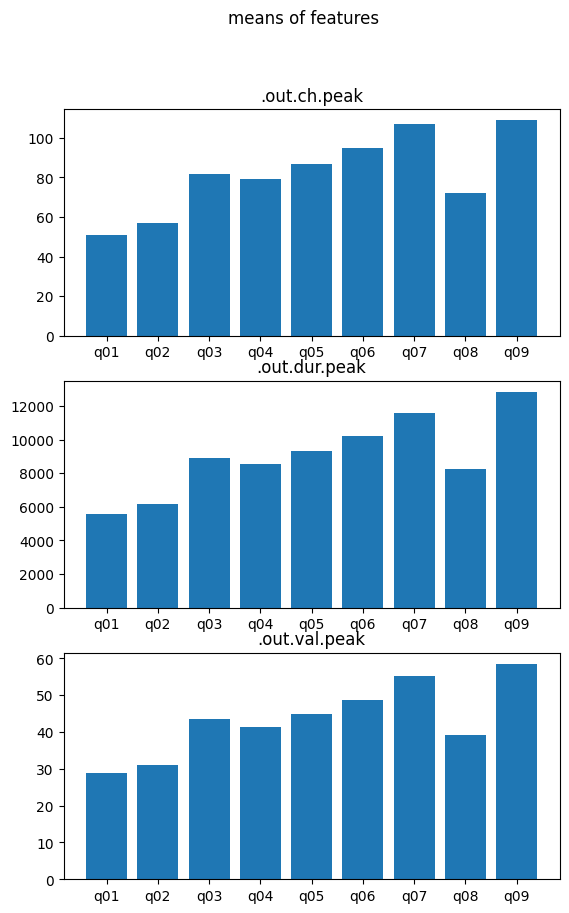

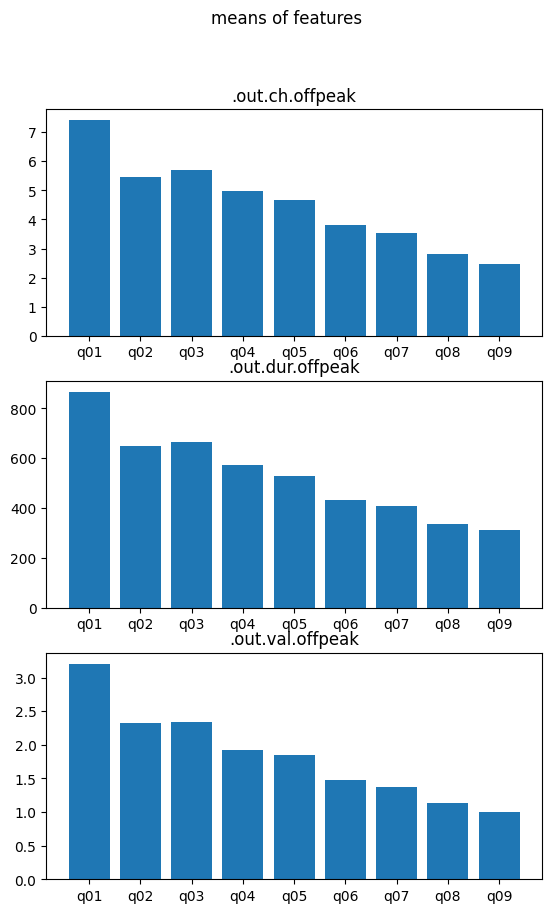

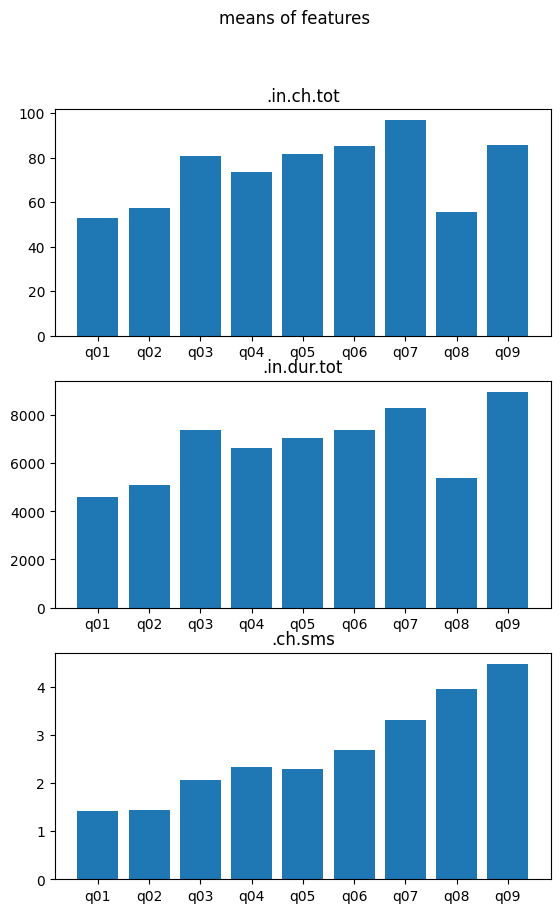

In [14]:
names_month_variables = [  
  '.out.ch.peak',                    # total monthly number of outgoing calls at times when the tariff is highest
  '.out.dur.peak',                   # total monthly duration of outgoing calls at times when the tariff is highest
  '.out.val.peak',                   # total monthly value of outgoing calls at times when the tariff is highest
  '.out.ch.offpeak',                 # total monthly number of outgoing calls during offpeak hours
  '.out.dur.offpeak',                # total monthly duration of outgoing calls during off-peak hours
  '.out.val.offpeak',                # total monthly value of outgoing calls during off-peak hours
  '.in.ch.tot',                      #     monthly number of incoming calls
  '.in.dur.tot',                     #     monthly duration of incoming calls
  '.ch.sms',                         #     monthly number of SMS sent
  '.ch.cc',                          #     monthly number of calls to the Customer Service Centre
]
months = ['q01','q02','q03','q04','q05','q06','q07','q08','q09']
# does mean value of predictors differ in each month?
def month_means(features, months: list[str]):
    description = train.describe()
    means = description.loc['mean']
  
    fig, axs = plt.subplots(len(features))
    fig.suptitle('means of features')
    fig.set_figheight(10)
    for i,feature in enumerate(features):
        feature_means = [means[m + feature] for m in months]
        axs[i].bar(months, feature_means)
        axs[i].title.set_text( feature)
    plt.show()


month_means(names_month_variables[0:3], months=months)
month_means(names_month_variables[3:6], months=months)
month_means(names_month_variables[6:9], months=months)


From previous graphs we can see that the mean values for month variables usually depends on the month, so from this we can say that probably months closer to the 10th month will be probaly more usefull, because they are more similar to the 10 th month. Since we can see increasing or decreasing trend during the year. 


## Correlation between variables dependent on the month 


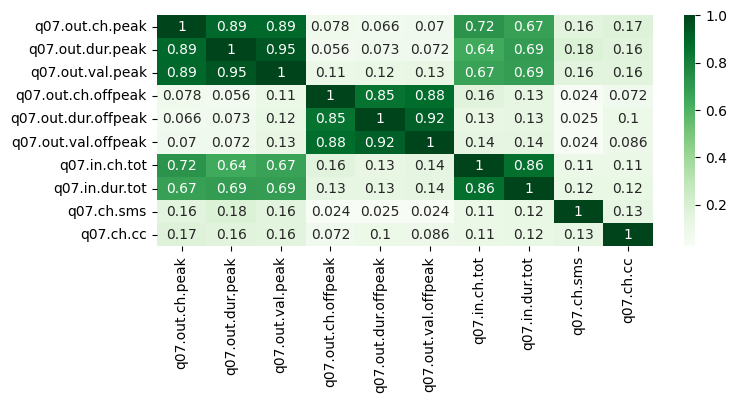

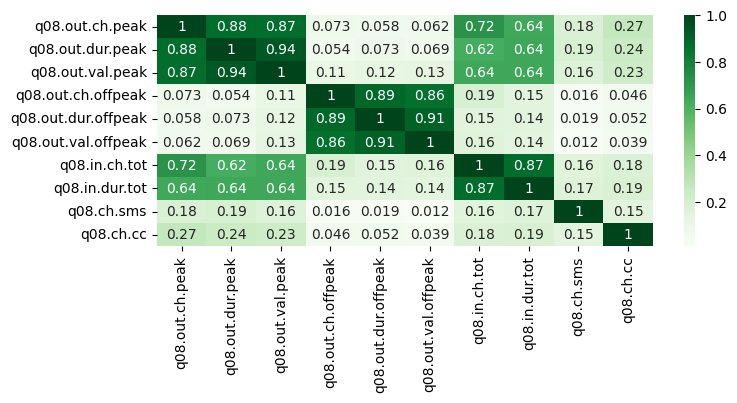

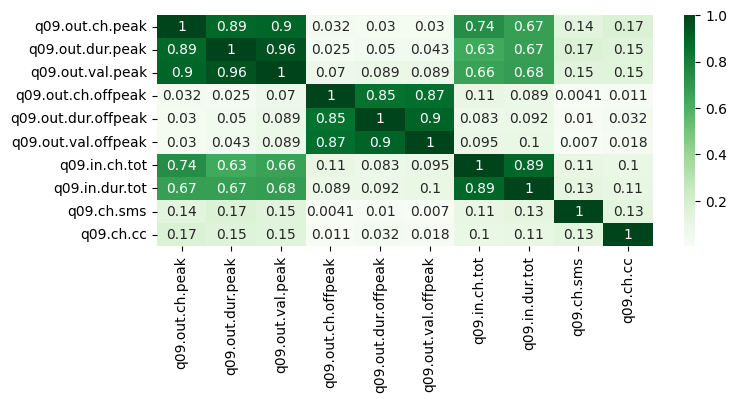

In [15]:
def corr_matrix_month_var(number):
   month = train.loc[:, [number + name for name in names_month_variables]] 
   
   corr = month.corr()
   corr.style.background_gradient(cmap='coolwarm')
   corr.style.background_gradient(cmap='coolwarm').format(precision=2)
   plt.figure(figsize=(8,3))
   sns.heatmap(corr, cmap="Greens",annot=True)
   plt.show()

for month in months[6:9]:
   corr_matrix_month_var(month)

# ['.out.ch.peak','.out.dur.peak', '.out.val.peak']
# ['.out.ch.offpeak', '.out.dur.offpeak', '.out.val.offpeak']
# ['.in.ch.tot', '.in.dur.tot']

We had drawn correlation matrix only for three months, but we can see that the correlations between variables are pretty similar in each month. This trend can be seen also in the rest of the months.
Also we identified three groups of features which are correlated with each other the three groups are: 

- '.out.ch.peak','.out.dur.peak', '.out.val.peak'
- '.out.ch.offpeak', '.out.dur.offpeak', '.out.val.offpeak'
- '.in.ch.tot', '.in.dur.tot'


In [39]:
# now we want to choose a month and use every feature which is related to it. 

def add_month(month, names):
    return [month + name for name in names]

# test model with all features witch is in given months or doesn't belong to any month
def test_months(months, month_features):
    features_names= []
    for m in months:
        features_names = features_names + add_month(m, month_features)
    features_names =  features_names + non_cat_features + cat_features 
    one_hot = OneHotEncoder()
    pattern = cat_features[0]
    for f in cat_features[1:]: pattern += '|'+ f
     
    transformer = ColumnTransformer([('cat_cols',one_hot, make_column_selector(pattern=pattern))],
                                     remainder= 'passthrough')
    pipe = Pipeline([
                     ('preprocessing', transformer),
                     ('model', GradientBoostingRegressor(n_estimators=150))])
    X_train_gb = train.loc[:,features_names]
    feature_selector = FeatureSelector()
    result = feature_selector.k_fold_cv(pipe, X_train_gb, y_train)
    print('months: ', months,', ',result)




In [38]:
for m in months:
   test_months([m],names_month_variables)

tested_months = ['q09']
for i in reversed(range(1,9)):
   tested_months.append('q' + str(0) + str(i))
   test_months(tested_months, names_month_variables)


months:  ['q01'] ,  2.648884668729022
months:  ['q02'] ,  2.631379716914083
months:  ['q03'] ,  2.6089583273032857
months:  ['q04'] ,  2.576998499550319
months:  ['q05'] ,  2.535268180223144
months:  ['q06'] ,  2.4901650554629717
months:  ['q07'] ,  2.401116831861412
months:  ['q08'] ,  2.369941167701954
months:  ['q09'] ,  1.9902430762381869
months:  ['q09', 'q08'] ,  1.9904482670394867
months:  ['q09', 'q08', 'q07'] ,  1.9892692375091419
months:  ['q09', 'q08', 'q07', 'q06'] ,  1.987934702927315
months:  ['q09', 'q08', 'q07', 'q06', 'q05'] ,  1.9887550427790408
months:  ['q09', 'q08', 'q07', 'q06', 'q05', 'q04'] ,  1.9902687237427563
months:  ['q09', 'q08', 'q07', 'q06', 'q05', 'q04', 'q03'] ,  1.992090185525912
months:  ['q09', 'q08', 'q07', 'q06', 'q05', 'q04', 'q03', 'q02'] ,  1.9892586956174854
months:  ['q09', 'q08', 'q07', 'q06', 'q05', 'q04', 'q03', 'q02', 'q01'] ,  1.9902230502585518


In [46]:
# previosly we found this groups of correlated features:
# ['.out.ch.peak','.out.dur.peak', '.out.val.peak']
# ['.out.ch.offpeak', '.out.dur.offpeak', '.out.val.offpeak']
# ['.in.ch.tot', '.in.dur.tot']
# we want to find out if we can use just one feature as a representative of each group 

def test_group(months, group):  
    print ('testing group: ', group)
    print('all vars')
    test_months(months, group)
    for var in group: 
        print('var:', var)
        test_months(months, [var])
    print('-'*50)
  

# we used only last 4 moths because other moths doesn't seems to have bigger influence in previous example
test_group(['q09', 'q08', 'q07', 'q06'], ['.out.ch.peak','.out.dur.peak', '.out.val.peak'])
test_group(['q09', 'q08', 'q07', 'q06'], ['.out.ch.offpeak', '.out.dur.offpeak', '.out.val.offpeak'])
test_group(['q09', 'q08', 'q07', 'q06'], ['.in.ch.tot', '.in.dur.tot'])




testing group:  ['.out.ch.peak', '.out.dur.peak', '.out.val.peak']
all vars
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.069109046406202
var: .out.ch.peak
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.0790728437615313
var: .out.dur.peak
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.1017401582284947
var: .out.val.peak
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.0841174733565553
--------------------------------------------------
testing group:  ['.out.ch.offpeak', '.out.dur.offpeak', '.out.val.offpeak']
all vars
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.604574720026668
var: .out.ch.offpeak
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.6041264458551265
var: .out.dur.offpeak
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.6005668408155715
var: .out.val.offpeak
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.604776578807596
--------------------------------------------------
testing group:  ['.in.ch.tot', '.in.dur.tot']
all vars
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.2893321563386966
var: .in.ch.tot
months: 

In [47]:
# to find out if it is better to put 2 features from first group than just one or all featues 
test_months(['q09', 'q08', 'q07', 'q06'], ['.out.ch.peak','.out.dur.peak', '.out.val.peak'])
test_months(['q09', 'q08', 'q07', 'q06'], ['.out.ch.peak', '.out.val.peak'])

months:  ['q09', 'q08', 'q07', 'q06'] ,  2.069519766001079
months:  ['q09', 'q08', 'q07', 'q06'] ,  2.069884653399352


### Conclusion 
Firstly we found out, that the features before 6 th month does not increase the performance of the model. But we can see that maybe having features from 6th to 9th month can slightly increase the prediction.
Than we tested each group of correlated features, to choose the best one. 
we choose folowing features:
   - from group1: .out.ch.peak, .out.val.peak
   - from group2: .out.dur.offpeak
   - from group3: .in.ch.tot, .in.dur.tot
   - feature which was not in any group of correlated features 


## Automatic Forward feature selection

Now we will try forward feature selection, but to get results faster we will reduce number of features acording to previous results.
 - we will use only months from the 6th to the 9th month
 - and we will get rid of this correlated features: .out.ch.offpeak, .out.val.offpeak, var: .out.dur.peak

When the choosen feature will be categorical, we will alwayse choose feature first and than transformed it into one-hot encoding
 

In [ ]:
import time


class FeaturesSubset:
    def __init__(self, cat_features, non_cat_features, months, month_features_names) -> None:
        self.cat_features = cat_features
        self.non_cat_features = non_cat_features
        self.months = months
        self.month_features_names = month_features_names

# try to use library but it doesn't work 
class My_Forward_selector:

 
    def evaluate_model(X : pd.DataFrame,y,estimator, features):
        feature_selector = FeatureSelector()
        X_train = X.loc[:,features]
        result = feature_selector.k_fold_cv(estimator, X_train, y)
        return result
    
    # fs algorithm 
    # the preprocesing and transforming of categorical features is hidden inside the model 
    # so we choose features by name and when we fitting the model we perform the transformation of categorical features 
    def forward_selection(X : pd.DataFrame,y,estimator, max, features):
        features_left = features
        best_features = []
        best_score = []
        actual_features = []
        for i in range(max):
            print(f"using {i+1} features")
            start = time.time()
            used_features = []
            score = []
            if features_left == []: break
                
            for f in features_left:
                #evaluate model with new feature 
                result = My_Forward_selector.evaluate_model(X, y, estimator, actual_features + [f])
                score.append(result)
                used_features.append(actual_features + [f])
            
            print(f"beast score for { i + 1} features: {min(score)}")
            
            best_features.append(used_features[score.index(min(score))])
            best_score.append(min(score))
            actual_features = best_features[-1]
            print(f"new feature: { actual_features[-1]}")
            
            features_left.remove(actual_features[-1])
            end = time.time()
            print(f"time {end - start}")
            print('='*20)
        return (best_score,best_features)

# return dataset with choosen features subset 
def features_subset(data : pd.DataFrame, fs : FeaturesSubset) -> pd.DataFrame:
    month_features = []
    for m in fs.months:
        for mfname in fs.month_features_names:
            month_features.append(m + mfname)

    features = fs.non_cat_features + fs.cat_features + month_features
    return data.loc[:, features], features

# find best subset of features and show results of ffs
def best_subset(pipe, fs : FeaturesSubset, output_features):
    one_hot = OneHotEncoder()

    #define pattern so the column transformer knows which features are categorical 
    pattern = cat_features[0]
    for f in cat_features[1:]: pattern += '|'+ f

    #hide preprocessing into pipeline
    transformer = ColumnTransformer([('cat_cols',one_hot, make_column_selector(pattern=pattern))],
                                     remainder= 'passthrough')
    pipe_w_preprocessing = Pipeline([('preprocessing', transformer)] + pipe)
    train_x, features = features_subset(train, fs)
    print(f"choosing from {features}")

    start = time.time()
    best_scores ,best_features = My_Forward_selector.forward_selection(train_x, y_train, pipe_w_preprocessing, output_features, features)
    end = time.time()
    print(f"feature selection took: {end - start}s")
    best_s = min(best_scores)
    best_f = best_features[best_scores.index(best_s)]

    plt.plot(best_scores)
    plt.title('feature selection, 5-fold cross-validation')
    plt.show()
    print(f"best score: {best_s}")
    print(f"features: {best_f}")

    print("all bests cores:")
    print('  ', best_scores)
    print("all bests features:")
    print('  ', best_features)
    
    print('-'*20)
    return best_f
    

In [49]:

selector = FeaturesSubset(
    cat_features = cat_features,
    non_cat_features = non_cat_features,
    months = ['q06','q07','q08','q09'],
    month_features_names = ['.out.ch.peak','.out.val.peak','.out.dur.offpeak','.in.ch.tot','.in.dur.tot','.ch.sms','.ch.cc']
)

pipe = [('gb',GradientBoostingRegressor(n_estimators=150))]

# can take hours !!!
best_features_gb = best_subset(pipe, selector, 50)



choosing from ['age', 'payment.method', 'sex', 'vas1', 'vas2', 'activation.zone', 'activation.channel', 'tariff.plan', 'q06.out.ch.peak', 'q06.out.val.peak', 'q06.out.dur.offpeak', 'q06.in.ch.tot', 'q06.in.dur.tot', 'q06.ch.sms', 'q06.ch.cc', 'q07.out.ch.peak', 'q07.out.val.peak', 'q07.out.dur.offpeak', 'q07.in.ch.tot', 'q07.in.dur.tot', 'q07.ch.sms', 'q07.ch.cc', 'q08.out.ch.peak', 'q08.out.val.peak', 'q08.out.dur.offpeak', 'q08.in.ch.tot', 'q08.in.dur.tot', 'q08.ch.sms', 'q08.ch.cc', 'q09.out.ch.peak', 'q09.out.val.peak', 'q09.out.dur.offpeak', 'q09.in.ch.tot', 'q09.in.dur.tot', 'q09.ch.sms', 'q09.ch.cc']
using 1 features
beast score for 1 features: 2.4129802613799365
new feature: q09.out.ch.peak
time 22.364632844924927
using 2 features
beast score for 2 features: 2.055536266741558
new feature: q09.out.dur.offpeak
time 25.810389041900635
using 3 features
beast score for 3 features: 2.0118340950069697
new feature: tariff.plan
time 27.415261030197144
using 4 features
beast score for 4 

## Testing  

Base on the forward selection of features we want to identify useful features  and make final model  

In [23]:
#['q09.out.ch.peak', 'q09.out.ch.offpeak', 'tariff.plan', 'age', 'q09.out.dur.peak', 'q05.in.ch.tot', 'q08.out.ch.peak', 'q06.out.dur.peak', 'q07.out.ch.peak', 'vas1', 'vas2', 'q09.in.ch.tot', 'activation.zone', 'q08.out.dur.offpeak', 'q08.ch.sms', 'activation.channel', 'q08.out.ch.offpeak', 'q05.ch.sms', 'q04.in.ch.tot', 'payment.method']
best_features_fs = ['tariff.plan',
                  'age',
                  'vas1', 
                  'vas2',
                  'payment.method',
                  'activation.zone',
                  'activation.channel',
                  'q09.out.ch.peak', 'q09.out.dur.peak',    'q09.out.ch.offpeak', 'q09.in.ch.tot',
                  'q08.out.ch.peak', 'q08.out.dur.offpeak', 'q08.out.ch.offpeak', 'q08.ch.sms',
                  'q07.out.ch.peak', 
                  'q06.out.dur.peak', 
                  'q05.in.ch.tot', 'q05.ch.sms',           
                  'q04.in.ch.tot']

#try to find some pattern ...but it is worst 
choosen_features = ['tariff.plan',
                    'age',
                    'vas1', 
                    'vas2',
                    'payment.method',
                    'activation.zone',
                    'activation.channel',
                    'q09.out.ch.peak', 'q09.out.dur.peak','q09.out.dur.offpeak', 'q09.out.ch.offpeak', 'q09.in.ch.tot',
                    'q08.out.ch.peak', 'q08.out.dur.peak','q08.out.dur.offpeak', 'q08.out.ch.offpeak', 'q08.in.ch.tot', 
                    'q07.out.ch.peak', 'q07.out.dur.peak', 'q07.in.ch.tot',
                    'q06.out.ch.peak', 'q06.out.dur.peak', 'q06.in.ch.tot',
                    'q05.in.ch.tot',           
                    'q04.in.ch.tot']

def test_features(features, pipe):

    one_hot = OneHotEncoder()
    pattern = cat_features[0]
    for f in cat_features[1:]: pattern += '|'+ f
     
    transformer = ColumnTransformer([('cat_cols',one_hot, make_column_selector(pattern=pattern))],
                                     remainder= 'passthrough')
    pipe = Pipeline([('preprocessing', transformer)] + pipe)
    X_train_gb = train.loc[:,features]
    feature_selector = FeatureSelector()
    result = feature_selector.k_fold_cv(pipe, X_train_gb, y_train)
    print(f"result: {result}")

In [24]:

# try to find better parameters with choosen features 
test_features(best_features_fs,[('gb',GradientBoostingRegressor())])
grid = {'gb__n_estimators': [100, 120, 150,],
        'gb__max_depth':[2,3,4],
        'gb__learning_rate' :[0.1,0.05]
        }
score_function = make_scorer(FeatureSelector().rmsle,greater_is_better=False)
one_hot = OneHotEncoder()
pattern = cat_features[0]
for f in cat_features[1:]: pattern += '|'+ f
 
transformer = ColumnTransformer([('cat_cols',one_hot, make_column_selector(pattern=pattern))],
                                 remainder= 'passthrough')
pipe = Pipeline([('preprocessing', transformer),('gb',GradientBoostingRegressor(n_estimators=150))] )
X_train_gb = train.loc[:, best_features_fs]
y_to_fit = np.log(y_train+1) 
grid_search = GridSearchCV(pipe,grid,verbose=4,scoring =score_function)
grid = grid_search.fit(X_train_gb,y_to_fit )
results = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
results.to_csv('results-gridSearch-gb-fs.csv')
display(results)

result: 1.9783229764560197
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-1.963 total time=   1.1s
[CV 2/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-2.031 total time=   1.1s
[CV 3/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-1.982 total time=   1.1s
[CV 4/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-2.014 total time=   1.1s
[CV 5/5] END gb__learning_rate=0.1, gb__max_depth=2, gb__n_estimators=100;, score=-2.008 total time=   1.1s


KeyboardInterrupt: 

In [ ]:
# had to do feature preparation again, because of the unigue values in test set 
features = best_features_fs
cat_best_f = ['tariff.plan',
                    'age',
                    'vas1', 
                    'vas2',
                    'payment.method',
                    'activation.zone',
                    'activation.channel']

train = pd.read_csv("phone_train.csv")
test = pd.read_csv("phone_validation.csv")

# Encode train and test sets
X_train = rm_feature(train, ['y'])
y_train = train['y']



X_train['label'] = 'train'
X_test['label'] = 'test'


concat_X = pd.concat([X_train, X_test])
concat_X = concat_X.loc[:,features +['label']]

concat_X = one_hot_encoding(concat_X, cat_best_f + ['label'])

X_train = concat_X[concat_X['label_train']==1]
X_test = concat_X[concat_X['label_test']==1]

X_train = X_train.drop(['label_train','label_test'], axis=1)
X_test = X_test.drop(['label_train','label_test'], axis=1)

In [ ]:

pipe = Pipeline([('gb',GradientBoostingRegressor(n_estimators=100, max_depth = 4))] )

data_gb = train.loc[:,best_features_fs]
y_to_fit = np.log(y_train+1)

pipe.fit(X_train, y_to_fit)
y_pred = np.exp(pipe.predict(X_test)) - 1
y_pred = np.maximum(0, y_pred)
with open('mySubmissionGB.txt','w') as file:
    for y in y_pred:
       file.write(str(y)+'\n')